In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# 1. Build a graph

In [8]:
matrix1 = tf.constant([[3., 3.]])
matrix2 = tf.constant([[2.],[2.]])

product = tf.matmul(matrix1, matrix2)

with tf.Session() as sess:
    result = sess.run(product)
    print(result)

[[ 12.]]


# 2. Variable

In [10]:
state = tf.Variable(0)
one = tf.constant(1)
new_value = tf.add(one, state)
update = tf.assign(state, new_value)

init_op = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init_op)
    for i in range(3):
        result = sess.run(update)
    print(result)

3


# 3. Feed

In [13]:
input1 = tf.placeholder(tf.float64)
input2 = tf.placeholder(tf.float64)

output = tf.mul(input1, input2)

with tf.Session() as sess:
    result = sess.run(output, feed_dict={input1:1,input2:2})
    print(result)

2.0


# 4. GAN

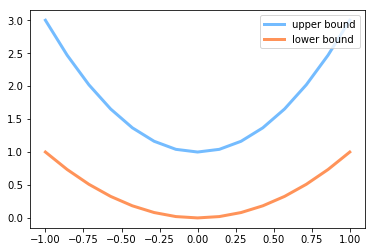

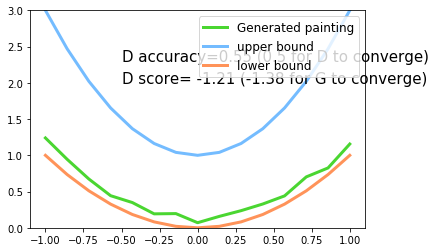

In [6]:
tf.set_random_seed(1)
np.random.seed(1)

# Hyper Parameters
BATCH_SIZE = 64
LR_G = 0.0001           # learning rate for generator
LR_D = 0.0001           # learning rate for discriminator
N_IDEAS = 5             # think of this as number of ideas for generating an art work (Generator)
ART_COMPONENTS = 15     # it could be total point G can draw in the canvas
PAINT_POINTS = np.vstack([np.linspace(-1, 1, ART_COMPONENTS) for _ in range(BATCH_SIZE)])

# show our beautiful painting range
plt.plot(PAINT_POINTS[0], 2 * np.power(PAINT_POINTS[0], 2) + 1, c='#74BCFF', lw=3, label='upper bound')
plt.plot(PAINT_POINTS[0], 1 * np.power(PAINT_POINTS[0], 2) + 0, c='#FF9359', lw=3, label='lower bound')
plt.legend(loc='upper right')
plt.show()


def artist_works():     # painting from the famous artist (real target)
    a = np.random.uniform(1, 2, size=BATCH_SIZE)[:, np.newaxis]
    paintings = a * np.power(PAINT_POINTS, 2) + (a-1)
    return paintings

G_in = tf.placeholder(tf.float32, shape=[None, N_IDEAS], name='Z')
G_W1 = tf.Variable(tf.truncated_normal([N_IDEAS, 128],stddev=0.1), name='G_W1')
G_b1 = tf.Variable(tf.zeros(shape=[128]), name='G_b1')
G_W2 = tf.Variable(tf.truncated_normal([128, ART_COMPONENTS]), name='G_W2')
G_b2 = tf.Variable(tf.zeros(shape=[ART_COMPONENTS]), name='G_b2')
theta_G = [G_W1, G_W2, G_b1, G_b2]

real_art = tf.placeholder(tf.float32, shape=[None, ART_COMPONENTS], name='X')
D_W1 = tf.Variable(tf.truncated_normal([ART_COMPONENTS, 128],stddev=0.1), name='D_W1')
D_b1 = tf.Variable(tf.zeros(shape=[128]), name='D_b1')
D_W2 = tf.Variable(tf.truncated_normal([128, 1]), name='D_W2')
D_b2 = tf.Variable(tf.zeros(shape=[1]), name='D_b2')
theta_D = [D_W1, D_W2, D_b1, D_b2]

with tf.variable_scope('Generator'):
    G_h1 = tf.nn.relu(tf.matmul(G_in, G_W1) + G_b1)
    G_out = tf.matmul(G_h1, G_W2) + G_b2

#     G_in = tf.placeholder(tf.float32, [None, N_IDEAS])          # random ideas (could from normal distribution) 
#     G_l1 = tf.layers.dense(G_in, 128, tf.nn.relu)
#     G_out = tf.layers.dense(G_l1, ART_COMPONENTS)               # making a painting from these random ideas

with tf.variable_scope('Discriminator'):
    D_h1 = tf.nn.relu(tf.matmul(real_art, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    prob_artist0 = tf.nn.sigmoid(D_logit)
    # reuse layers for generator
    D_h2 = tf.nn.relu(tf.matmul(G_out, D_W1) + D_b1)
    D_logit2 = tf.matmul(D_h2, D_W2) + D_b2
    prob_artist1 = tf.nn.sigmoid(D_logit2)

#     real_art = tf.placeholder(tf.float32, [None, ART_COMPONENTS], name='real_in')   # receive art work from the famous artist
#     D_l0 = tf.layers.dense(real_art, 128, tf.nn.relu, name='l')
#     prob_artist0 = tf.layers.dense(D_l0, 1, tf.nn.sigmoid, name='out')              # probability that the art work is made by artist
#     # reuse layers for generator
#     D_l1 = tf.layers.dense(G_out, 128, tf.nn.relu, name='l', reuse=True)            # receive art work from a newbie like G
#     prob_artist1 = tf.layers.dense(D_l1, 1, tf.nn.sigmoid, name='out', reuse=True)  # probability that the art work is made by artist

D_loss = -tf.reduce_mean(tf.log(prob_artist0) + tf.log(1-prob_artist1))
G_loss = tf.reduce_mean(tf.log(1-prob_artist1))

train_D = tf.train.AdamOptimizer(LR_D).minimize(
    D_loss, var_list=theta_D)
train_G = tf.train.AdamOptimizer(LR_G).minimize(
    G_loss, var_list=theta_G)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

plt.ion()   # something about continuous plotting
for step in range(5000):
    artist_paintings = artist_works()           # real painting from artist
    G_ideas = np.random.randn(BATCH_SIZE, N_IDEAS)
    G_paintings, pa0, Dl = sess.run([G_out, prob_artist0, D_loss, train_D, train_G],    # train and get results
                                    {G_in: G_ideas, real_art: artist_paintings})[:3]

    if step % 50 == 0:  # plotting
        plt.cla()
        plt.plot(PAINT_POINTS[0], G_paintings[0], c='#4AD631', lw=3, label='Generated painting',)
        plt.plot(PAINT_POINTS[0], 2 * np.power(PAINT_POINTS[0], 2) + 1, c='#74BCFF', lw=3, label='upper bound')
        plt.plot(PAINT_POINTS[0], 1 * np.power(PAINT_POINTS[0], 2) + 0, c='#FF9359', lw=3, label='lower bound')
        plt.text(-.5, 2.3, 'D accuracy=%.2f (0.5 for D to converge)' % pa0.mean(), fontdict={'size': 15})
        plt.text(-.5, 2, 'D score= %.2f (-1.38 for G to converge)' % -Dl, fontdict={'size': 15})
        plt.ylim((0, 3)); plt.legend(loc='upper right', fontsize=12); plt.draw(); plt.pause(0.01)

plt.ioff()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

mb_size = 64
Z_dim = 100
X_dim = mnist.train.images.shape[1]
y_dim = mnist.train.labels.shape[1]
h_dim = 128


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


""" Discriminator Net model """
X = tf.placeholder(tf.float32, shape=[None, 784])
y = tf.placeholder(tf.float32, shape=[None, y_dim])

D_W1 = tf.Variable(xavier_init([X_dim + y_dim, h_dim]))
D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

D_W2 = tf.Variable(xavier_init([h_dim, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]


def discriminator(x, y):
    inputs = tf.concat(values=[x, y], concat_dim=1)
    D_h1 = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit


""" Generator Net model """
Z = tf.placeholder(tf.float32, shape=[None, Z_dim])

G_W1 = tf.Variable(xavier_init([Z_dim + y_dim, h_dim]))
G_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

G_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_G = [G_W1, G_W2, G_b1, G_b2]


def generator(z, y):
    inputs = tf.concat(values=[z, y], concat_dim=1 )
    G_h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob


def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])


def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig


G_sample = generator(Z, y)
D_real, D_logit_real = discriminator(X, y)
D_fake, D_logit_fake = discriminator(G_sample, y)

D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, targets=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, targets=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, targets=tf.ones_like(D_logit_fake)))

D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)


sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0

for it in range(10000):
    if it % 1000 == 0:
        n_sample = 16

        Z_sample = sample_Z(n_sample, Z_dim)
        y_sample = np.zeros(shape=[n_sample, y_dim])
        y_sample[:, 6] = 1

        samples = sess.run(G_sample, feed_dict={Z: Z_sample, y:y_sample})

        fig = plot(samples)
        plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)

    X_mb, y_mb = mnist.train.next_batch(mb_size)

    Z_sample = sample_Z(mb_size, Z_dim)
    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: Z_sample, y:y_mb})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: Z_sample, y:y_mb})

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Iter: 0
D loss: 1.463
G_loss: 2.093

Iter: 1000
D loss: 0.02297
G_loss: 10.43

Iter: 2000
D loss: 0.006577
G_loss: 6.518

Iter: 3000
D loss: 0.07902
G_loss: 4.32

Iter: 4000
D loss: 0.05021
G_loss: 6.233

Iter: 5000
D loss: 0.1376
G_loss: 4.766

